# Supervised CARE Training

Here we use CARE training using noisy images as input and averaged noisy images as target.

In [2]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../../')
from unet.model import UNet
from pn2v import utils
from pn2v import histNoiseModel
from pn2v import training
from tifffile import imread
# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Download data
Download the data from https://zenodo.org/record/5156913/files/Convallaria_diaphragm.zip?download=1. Here we show the pipeline for Convallaria dataset. Save the dataset in an appropriate path. For us, the path is the data folder which exists at `../../../`. For Convallaria, the data to be denoised is named ```20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif```.

In [2]:
# Download data
import os
import urllib
import zipfile

if not os.path.isdir('../../../data'):
    os.mkdir('../../../data')

zipPath="../../../data/Convallaria_diaphragm.zip"
if not os.path.exists(zipPath):  
    data = urllib.request.urlretrieve('https://zenodo.org/record/5156913/files/Convallaria_diaphragm.zip?download=1', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("../../../data")


### Load Data
#### Ensure ```filename = 20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif``` and specify the ```dataname```  

In [19]:
path='../dataset/'
fileName='pollen.spd1.0098.tiff'
dataName='sem' # This will be used to name the "care" model

#### Noisy Data (Input to network)

In [20]:
data=imread(path+fileName)
nameModel=dataName+'_care'

#### Ground truth  Data (Target of Network)

In [21]:
dataGT = np.mean(data, axis=0)[np.newaxis,...,np.newaxis]

In [22]:
data=data[...,np.newaxis]
dataGT = np.repeat(dataGT, 768, axis=0)

print("Shape of Raw Noisy Image is ", data.shape, "; Shape of Target Image is ", dataGT.shape)
data = np.concatenate((data,dataGT),axis=-1)
# Add the target image as a second channel to `data`
print("Shape of `data` is ", data.shape)

Shape of Raw Noisy Image is  (768, 1024, 1) ; Shape of Target Image is  (768, 1024, 1)
Shape of `data` is  (768, 1024, 2)


IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

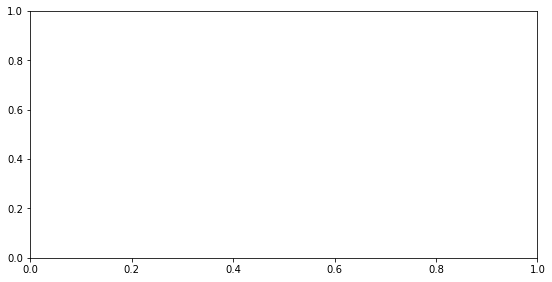

In [23]:
plt.figure(figsize=(20, 10))
plt.subplot(2,2,1)
plt.imshow(data[0,:512,:512,0])
plt.title('Top Left')

plt.subplot(2,2,2)
plt.imshow(data[0,:512,512:,0])
plt.title('Top Right')

plt.subplot(2,2,3)
plt.imshow(data[0,512:,:512,0])
plt.title('Bottom Left')

plt.subplot(2,2,4)
plt.imshow(data[0,512:,512:,0])
plt.title('Bottom Right')
plt.show()

# We now crop away the top-left portion of the data since this portion will be used later for testing
data=np.concatenate( (data[:,512:,512:,:], data[:,:512,512:,:], data[:,512:,:512,:])  )

### Create the Network and Train it
This can take a while. Ensure that `supervised` = `True`.

In [24]:
# The N2V network requires only a single output unit per pixel
net = UNet(1, depth=3)

# Split training and validation data.
my_train_data=data[:-5].copy()
my_val_data=data[-5:].copy()

# Start training.
trainHist, valHist = training.trainNetwork(net=net, trainData=my_train_data, valData=my_val_data,
                                           postfix=nameModel, directory=path, noiseModel=None,
                                           device=device, numOfEpochs= 200, stepsPerEpoch=5, 
                                           virtualBatchSize=20, batchSize=1, learningRate=1e-3, supervised=True)

IndexError: tuple index out of range

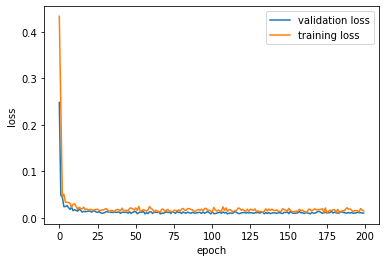

In [9]:
# Let's look at the training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(valHist, label='validation loss')
plt.plot(trainHist, label='training loss')
plt.legend()
plt.show()